<a href="https://colab.research.google.com/github/DIFACQUIM/DNMT1-Protocol/blob/main/Scaffolds_Nucleoside_analogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Code based on the work published by Dr. Patrick Walters at:** <br>
http://practicalcheminformatics.blogspot.com/2021/10/exploratory-data-analysis-with.html

# Installation of required packages

In [37]:
!pip install rdkit-pypi mols2grid ipywidgets

# Installation of required libraries

In [38]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmilesFromSmiles
import mols2grid
from tqdm.auto import tqdm
from ipywidgets import widgets
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True

Enable Pandas **progress_apply**:

In [39]:
tqdm.pandas()

# Setup

Read the dataset from the GitHub repository and load it as data frame "df":

In [40]:
df = pd.read_csv("https://raw.githubusercontent.com/DIFACQUIM/DNMT1-Protocol/main/ChEMBL32_DNMT1_196.csv")
df.head()

,molecule_chembl_id,smiles,scaffold,IC50,std_units,pIC50,alogp,hba,hbd,full_mwt,num_ro5_violations,psa,heavy_atoms,document_chembl_id
0,CHEMBL3087498,CC(C)N(CCCNC(=O)Nc1ccc(C(C)(C)C)cc1)C[C@H]1O[C...,O=C(NCCCNC[C@@H]1CC[C@H](n2ccc3cncnc32)O1)Nc1c...,0.3,nM,9.522879,3.61,9,5,618.58,1,150.79,40,CHEMBL4477246
1,CHEMBL2171169,CC(C)N(CCCNC(=O)Nc1ccc(C(C)(C)C)cc1)C[C@H]1O[C...,O=C(NCCCNC[C@@H]1CC[C@H](n2cnc3cncnc32)O1)Nc1c...,2.9,nM,8.537602,2.25,10,5,540.67,1,163.68,39,CHEMBL4477246
2,CHEMBL83747,O=C(NCCSSCCNC(=O)/C(Cc1ccc(O)c(Br)c1)=N/O)/C(C...,N=C(Cc1ccccc1)C(=O)NCCSSCCNC(=O)C(=N)Cc1ccccc1,18.6,nM,7.730487,3.68,10,6,664.40,2,163.84,36,CHEMBL2046381
3,CHEMBL4215326,COc1cc2c(NC3CCN(C)CC3)cc(-c3ccc(C)o3)nc2cc1OC1...,c1coc(-c2cc(NC3CCNCC3)c3ccc(OC4CC5(CNC5)C4)cc3...,21.0,nM,7.677781,4.79,7,1,476.62,0,63.00,35,CHEMBL4190398
4,CHEMBL1201129,Nc1ncn([C@H]2C[C@H](O)[C@@H](CO)O2)c(=O)n1,O=c1ncncn1[C@H]1CCCO1,30.0,nM,7.522879,-2.14,8,3,228.21,0,123.49,16,CHEMBL4130634


Create a column with the Bemis/Murcko scaffolds:

In [41]:
df['framework'] = df.smiles.progress_apply(MurckoScaffoldSmilesFromSmiles)

  0%|          | 0/196 [00:00<?, ?it/s]

Create a column with RDKit molecular objects:

In [42]:
df['mol'] = df.smiles.progress_apply(Chem.MolFromSmiles)

  0%|          | 0/196 [00:00<?, ?it/s]

# Create a DataFrame to organize the scaffolds

As a first step, the frequency of each scaffold is counted. This is done with the function **value_counts** from Pandas. The result of this function is converted to a data frame:

In [43]:
scaffold_df = df.framework.value_counts().reset_index().copy()
scaffold_df.columns = ["scaffold","count"]
# copy the index column for the dataframe to scaffold_idx
scaffold_df['scaffold_idx'] = scaffold_df.index
scaffold_df

,scaffold,count,scaffold_idx
0,c1coc(-c2cc(NC3CCNCC3)c3ccc(OCCCN4CCCC4)cc3n2)c1,16,0
1,c1ncc2ncn(C3CCCO3)c2n1,10,1
2,c1ncc2ncn(C3CCC(CSC4CCNC4)O3)c2n1,7,2
3,c1coc(-c2cc(NCC3CCNCC3)c3ccc(OCCCN4CCCC4)cc3n2)c1,4,3
4,c1ccc(-c2ccc(CCNc3ncnc4c3ncn4C3CCC(CSC4CCNC4)O...,4,4
...,...,...,...
129,c1cc(-c2cc(NC3CCNCC3)c3ccc(OCCCN4CCCC4)cc3n2)co1,1,129
130,c1cc(-c2cc(NC3CCNCC3)c3ccc(OCCCN4CCCC4)cc3n2)n...,1,130
131,C1=C(c2cc(NC3CCNCC3)c3ccc(OCCCN4CCCC4)cc3n2)CCOC1,1,131
132,c1cc2c(NC3CCNCC3)cc(N3CCNCC3)nc2cc1OCCCN1CCCC1,1,132


A link is created between the input data frame (df) and the data frame with the information of the scaffolds (scaffold_df). For this, we need a dictionary that maps the scaffold from "df" to the corresponding number in the index of "scaffold_df":


In [44]:
scaffold_dict = dict(zip(scaffold_df.scaffold,scaffold_df.index))
df['scaffold_idx'] = [scaffold_dict[x] for x in df.framework]

# Inspect the structures

Generate 2D coordinates for the scaffolds:

In [45]:
scaffold_df['mol'] = scaffold_df['scaffold'].apply(Chem.MolFromSmiles)
crds_ok = scaffold_df.mol.progress_apply(AllChem.Compute2DCoords)

  0%|          | 0/134 [00:00<?, ?it/s]

Verify the presence of the molecule of interest in the data frame with the ChEMBL ID:

In [46]:
#ID of S-adenosyl-L-homocysteine (SAH)
(df['molecule_chembl_id'] == "CHEMBL418052").value_counts()

False    195
True       1
Name: molecule_chembl_id, dtype: int64

Search of the ID's of SAH, azacitidine and decitabine (nucleoside analogs):

In [47]:
nucleosides = df[(df['molecule_chembl_id'] == "CHEMBL418052") | (df['molecule_chembl_id'] == "CHEMBL1489") | (df['molecule_chembl_id'] == "CHEMBL1201129")]
nucleosides

,molecule_chembl_id,smiles,scaffold,IC50,std_units,pIC50,alogp,hba,hbd,full_mwt,num_ro5_violations,psa,heavy_atoms,document_chembl_id,framework,mol,scaffold_idx
4,CHEMBL1201129,Nc1ncn([C@H]2C[C@H](O)[C@@H](CO)O2)c(=O)n1,O=c1ncncn1[C@H]1CCCO1,30.0,nM,7.522879,-2.14,8,3,228.21,0,123.49,16,CHEMBL4130634,O=c1ncncn1C1CCCO1,<rdkit.Chem.rdchem.Mol object at 0x78225eff03c0>,27
38,CHEMBL1489,Nc1ncn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)n1,O=c1ncncn1[C@H]1CCCO1,300.0,nM,6.522879,-3.17,9,4,244.21,0,143.72,17,CHEMBL4130634,O=c1ncncn1C1CCCO1,<rdkit.Chem.rdchem.Mol object at 0x78225eff12a0>,27
98,CHEMBL418052,Nc1ncnc2c1ncn2[C@@H]1O[C@H](CSCC[C@H](N)C(=O)O...,c1ncc2ncn([C@H]3CCCO3)c2n1,2000.0,nM,5.698970,-1.44,11,5,384.42,1,182.63,26,CHEMBL1151871,c1ncc2ncn(C3CCCO3)c2n1,<rdkit.Chem.rdchem.Mol object at 0x78225eff2ce0>,1


Define a new list with the SMILES of every scaffold found:

In [48]:
 scaffold_nucleosides = list((nucleosides['framework']).unique())
 scaffold_nucleosides

['O=c1ncncn1C1CCCO1', 'c1ncc2ncn(C3CCCO3)c2n1']

Visualization of the found scaffolds:

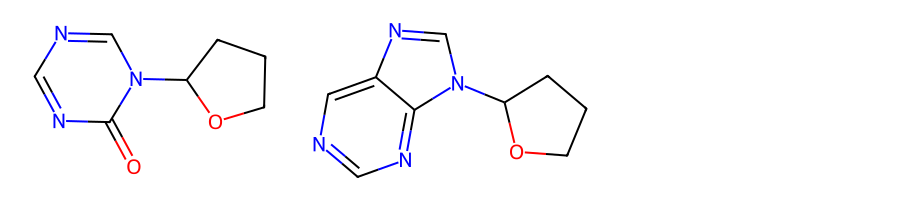

In [49]:
Scaffolds = [Chem.MolFromSmiles(x) for x in scaffold_nucleosides]
MOL =Chem.Draw.MolsToGridImage(Scaffolds, molsPerRow=3, subImgSize=(300, 200))
MOL

Search of compounds with the same scaffold:

In [50]:
df[df['scaffold_idx'] == 5]

,molecule_chembl_id,smiles,scaffold,IC50,std_units,pIC50,alogp,hba,hbd,full_mwt,num_ro5_violations,psa,heavy_atoms,document_chembl_id,framework,mol,scaffold_idx
14,CHEMBL4588797,N#Cc1cn([C@@H]2O[C@H](CSCC[C@H](N)C(=O)O)[C@@H...,c1ncc2ccn([C@H]3CCCO3)c2n1,150.0,nM,6.823909,-0.96,11,5,408.44,1,193.53,28,CHEMBL4477246,c1ncc2ccn(C3CCCO3)c2n1,<rdkit.Chem.rdchem.Mol object at 0x78225eff0820>,5
91,CHEMBL552309,Nc1ncnc2c1ccn2[C@@H]1O[C@H](CSCC[C@H](N)C(=O)O...,c1ncc2ccn([C@H]3CCCO3)c2n1,1500.0,nM,5.823909,-0.83,10,5,383.43,0,169.74,26,CHEMBL1151871,c1ncc2ccn(C3CCCO3)c2n1,<rdkit.Chem.rdchem.Mol object at 0x78225eff29d0>,5
97,CHEMBL2349526,Nc1ncnc2c1c(Br)cn2[C@@H]1O[C@H](CSCC[C@H](N)C(...,c1ncc2ccn([C@H]3CCCO3)c2n1,1900.0,nM,5.721246,-0.07,10,5,462.33,0,169.74,27,CHEMBL2346640,c1ncc2ccn(C3CCCO3)c2n1,<rdkit.Chem.rdchem.Mol object at 0x78225eff2c70>,5


# Substructure search

Define a query with the SMARTS of the chosen scaffold:

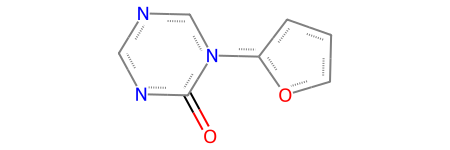

In [51]:
#Azacitidine scaffold
Aza_scaffold = "O=c1ncncn1C1CCCO1"
query = Chem.MolFromSmarts(Aza_scaffold)
query

Create a new column to indicate if the molecule contains the substructure:

In [52]:
df['match'] = [x.HasSubstructMatch(query) for x in df.mol]

Count of molecules with the substructure:

In [53]:
df.match.value_counts()

False    194
True       2
Name: match, dtype: int64

Discard molecules with the selected scaffold and explore the rest:

In [54]:
scaf_df_v2 = df.query('match==False').framework.value_counts().reset_index()
scaf_df_v2.columns = ["Scaffold","Count"]
mols2grid.display(scaf_df_v2,smiles_col="Scaffold")

MolGridWidget()

Create a new data frame with the molecules that do not contain the query substructure:

In [55]:
df['match'] = [x.HasSubstructMatch(query) for x in df.mol]
df_v2 = df[df['match'] == False]
df_v2

,molecule_chembl_id,smiles,scaffold,IC50,std_units,pIC50,alogp,hba,hbd,full_mwt,num_ro5_violations,psa,heavy_atoms,document_chembl_id,framework,mol,scaffold_idx,match
0,CHEMBL3087498,CC(C)N(CCCNC(=O)Nc1ccc(C(C)(C)C)cc1)C[C@H]1O[C...,O=C(NCCCNC[C@@H]1CC[C@H](n2ccc3cncnc32)O1)Nc1c...,0.3,nM,9.522879,3.61,9,5,618.58,1,150.79,40,CHEMBL4477246,O=C(NCCCNCC1CCC(n2ccc3cncnc32)O1)Nc1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x78225eff0200>,36,False
1,CHEMBL2171169,CC(C)N(CCCNC(=O)Nc1ccc(C(C)(C)C)cc1)C[C@H]1O[C...,O=C(NCCCNC[C@@H]1CC[C@H](n2cnc3cncnc32)O1)Nc1c...,2.9,nM,8.537602,2.25,10,5,540.67,1,163.68,39,CHEMBL4477246,O=C(NCCCNCC1CCC(n2cnc3cncnc32)O1)Nc1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x78225eff0040>,115,False
2,CHEMBL83747,O=C(NCCSSCCNC(=O)/C(Cc1ccc(O)c(Br)c1)=N/O)/C(C...,N=C(Cc1ccccc1)C(=O)NCCSSCCNC(=O)C(=N)Cc1ccccc1,18.6,nM,7.730487,3.68,10,6,664.40,2,163.84,36,CHEMBL2046381,N=C(Cc1ccccc1)C(=O)NCCSSCCNC(=O)C(=N)Cc1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x78225eff02e0>,104,False
3,CHEMBL4215326,COc1cc2c(NC3CCN(C)CC3)cc(-c3ccc(C)o3)nc2cc1OC1...,c1coc(-c2cc(NC3CCNCC3)c3ccc(OC4CC5(CNC5)C4)cc3...,21.0,nM,7.677781,4.79,7,1,476.62,0,63.00,35,CHEMBL4190398,c1coc(-c2cc(NC3CCNCC3)c3ccc(OC4CC5(CNC5)C4)cc3...,<rdkit.Chem.rdchem.Mol object at 0x78225eff0350>,26,False
5,CHEMBL4208004,COc1cc2c(NCC3CCN(C)CC3)cc(-c3ccc(C)o3)nc2cc1OC...,c1coc(-c2cc(NCC3CCNCC3)c3ccc(OCCCN4CCCC4)cc3n2)c1,32.0,nM,7.494850,5.43,7,1,492.66,1,63.00,36,CHEMBL4190398,c1coc(-c2cc(NCC3CCNCC3)c3ccc(OCCCN4CCCC4)cc3n2)c1,<rdkit.Chem.rdchem.Mol object at 0x78225eff0430>,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,CHEMBL1916683,CN1CC2ON=C(Cc3ccc([N+](=O)[O-])cc3)C2C1,c1ccc(CC2=NOC3CNCC23)cc1,310000.0,nM,3.508638,1.45,5,0,261.28,0,67.97,19,CHEMBL1914404,c1ccc(CC2=NOC3CNCC23)cc1,<rdkit.Chem.rdchem.Mol object at 0x78225eff5620>,24,False
192,CHEMBL1564869,O=C(O)[C@H](Cc1c[nH]c2ccccc12)N1C(=O)c2ccccc2C1=O,O=C1c2ccccc2C(=O)N1CCc1c[nH]c2ccccc12,390000.0,nM,3.408935,2.46,3,2,334.33,0,90.47,25,CHEMBL3108732,O=C1c2ccccc2C(=O)N1CCc1c[nH]c2ccccc12,<rdkit.Chem.rdchem.Mol object at 0x78225eff5690>,11,False
193,CHEMBL1916680,CN1CC2ON=C(c3ccc(N)cc3)C2C1,c1ccc(C2=NOC3CNCC23)cc1,570000.0,nM,3.244125,0.93,4,1,217.27,0,50.85,16,CHEMBL1914404,c1ccc(C2=NOC3CNCC23)cc1,<rdkit.Chem.rdchem.Mol object at 0x78225eff5700>,53,False
194,CHEMBL1916684,COc1ccc(CC2=NOC3CN(C)CC23)cc1,c1ccc(CC2=NOC3CNCC23)cc1,1130000.0,nM,2.946922,1.55,4,0,246.31,0,34.06,18,CHEMBL1914404,c1ccc(CC2=NOC3CNCC23)cc1,<rdkit.Chem.rdchem.Mol object at 0x78225eff5770>,24,False


Repeat with the chosen scaffolds...

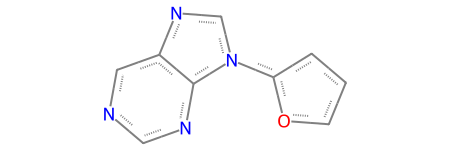

In [56]:
SAH_scaffold = "c1ncc2ncn(C3CCCO3)c2n1"
query = Chem.MolFromSmarts(SAH_scaffold)
query

In [57]:
df_v2['match'] = [x.HasSubstructMatch(query) for x in df_v2.mol]

<ipython-input-57-9dce8d294057>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_v2['match'] = [x.HasSubstructMatch(query) for x in df_v2.mol]


In [58]:
df_v2.match.value_counts()

False    157
True      37
Name: match, dtype: int64

In [59]:
scaf_df_v3 = df_v2.query('match==False').framework.value_counts().reset_index()
scaf_df_v3.columns = ["Scaffold","Count"]
mols2grid.display(scaf_df_v3,smiles_col="Scaffold")

MolGridWidget()

In [60]:
df_v2['match'] = [x.HasSubstructMatch(query) for x in df_v2.mol]
df_v3 = df_v2[df_v2['match'] == False]
df_v3

<ipython-input-60-3438a80dcb94>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_v2['match'] = [x.HasSubstructMatch(query) for x in df_v2.mol]


,molecule_chembl_id,smiles,scaffold,IC50,std_units,pIC50,alogp,hba,hbd,full_mwt,num_ro5_violations,psa,heavy_atoms,document_chembl_id,framework,mol,scaffold_idx,match
0,CHEMBL3087498,CC(C)N(CCCNC(=O)Nc1ccc(C(C)(C)C)cc1)C[C@H]1O[C...,O=C(NCCCNC[C@@H]1CC[C@H](n2ccc3cncnc32)O1)Nc1c...,0.3,nM,9.522879,3.61,9,5,618.58,1,150.79,40,CHEMBL4477246,O=C(NCCCNCC1CCC(n2ccc3cncnc32)O1)Nc1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x78225eff0200>,36,False
2,CHEMBL83747,O=C(NCCSSCCNC(=O)/C(Cc1ccc(O)c(Br)c1)=N/O)/C(C...,N=C(Cc1ccccc1)C(=O)NCCSSCCNC(=O)C(=N)Cc1ccccc1,18.6,nM,7.730487,3.68,10,6,664.40,2,163.84,36,CHEMBL2046381,N=C(Cc1ccccc1)C(=O)NCCSSCCNC(=O)C(=N)Cc1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x78225eff02e0>,104,False
3,CHEMBL4215326,COc1cc2c(NC3CCN(C)CC3)cc(-c3ccc(C)o3)nc2cc1OC1...,c1coc(-c2cc(NC3CCNCC3)c3ccc(OC4CC5(CNC5)C4)cc3...,21.0,nM,7.677781,4.79,7,1,476.62,0,63.00,35,CHEMBL4190398,c1coc(-c2cc(NC3CCNCC3)c3ccc(OC4CC5(CNC5)C4)cc3...,<rdkit.Chem.rdchem.Mol object at 0x78225eff0350>,26,False
5,CHEMBL4208004,COc1cc2c(NCC3CCN(C)CC3)cc(-c3ccc(C)o3)nc2cc1OC...,c1coc(-c2cc(NCC3CCNCC3)c3ccc(OCCCN4CCCC4)cc3n2)c1,32.0,nM,7.494850,5.43,7,1,492.66,1,63.00,36,CHEMBL4190398,c1coc(-c2cc(NCC3CCNCC3)c3ccc(OCCCN4CCCC4)cc3n2)c1,<rdkit.Chem.rdchem.Mol object at 0x78225eff0430>,3,False
6,CHEMBL4212905,CCc1ccc(-c2cc(NCC3CCN(C)CC3)c3cc(OC)c(OCCCN4CC...,c1coc(-c2cc(NCC3CCNCC3)c3ccc(OCCCN4CCCC4)cc3n2)c1,40.0,nM,7.397940,5.68,7,1,506.69,2,63.00,37,CHEMBL4190398,c1coc(-c2cc(NCC3CCNCC3)c3ccc(OCCCN4CCCC4)cc3n2)c1,<rdkit.Chem.rdchem.Mol object at 0x78225eff04a0>,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,CHEMBL1916683,CN1CC2ON=C(Cc3ccc([N+](=O)[O-])cc3)C2C1,c1ccc(CC2=NOC3CNCC23)cc1,310000.0,nM,3.508638,1.45,5,0,261.28,0,67.97,19,CHEMBL1914404,c1ccc(CC2=NOC3CNCC23)cc1,<rdkit.Chem.rdchem.Mol object at 0x78225eff5620>,24,False
192,CHEMBL1564869,O=C(O)[C@H](Cc1c[nH]c2ccccc12)N1C(=O)c2ccccc2C1=O,O=C1c2ccccc2C(=O)N1CCc1c[nH]c2ccccc12,390000.0,nM,3.408935,2.46,3,2,334.33,0,90.47,25,CHEMBL3108732,O=C1c2ccccc2C(=O)N1CCc1c[nH]c2ccccc12,<rdkit.Chem.rdchem.Mol object at 0x78225eff5690>,11,False
193,CHEMBL1916680,CN1CC2ON=C(c3ccc(N)cc3)C2C1,c1ccc(C2=NOC3CNCC23)cc1,570000.0,nM,3.244125,0.93,4,1,217.27,0,50.85,16,CHEMBL1914404,c1ccc(C2=NOC3CNCC23)cc1,<rdkit.Chem.rdchem.Mol object at 0x78225eff5700>,53,False
194,CHEMBL1916684,COc1ccc(CC2=NOC3CN(C)CC23)cc1,c1ccc(CC2=NOC3CNCC23)cc1,1130000.0,nM,2.946922,1.55,4,0,246.31,0,34.06,18,CHEMBL1914404,c1ccc(CC2=NOC3CNCC23)cc1,<rdkit.Chem.rdchem.Mol object at 0x78225eff5770>,24,False


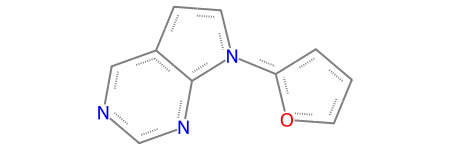

In [61]:
#Another scaffold found in nucleoside analogs
Another_scaffold = "c1ncc2ccn(C3CCCO3)c2n1"
query = Chem.MolFromSmarts(Another_scaffold)
query

In [62]:
df_v3['match'] = [x.HasSubstructMatch(query) for x in df_v3.mol]

<ipython-input-62-92a24fbd089e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_v3['match'] = [x.HasSubstructMatch(query) for x in df_v3.mol]


In [63]:
df_v3.match.value_counts()

False    153
True       4
Name: match, dtype: int64

In [64]:
df_v3['match'] = [x.HasSubstructMatch(query) for x in df_v3.mol]
df_v4 = df_v3[df_v3['match'] == False]
df_v4

<ipython-input-64-0b1f4b4a9b27>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_v3['match'] = [x.HasSubstructMatch(query) for x in df_v3.mol]


,molecule_chembl_id,smiles,scaffold,IC50,std_units,pIC50,alogp,hba,hbd,full_mwt,num_ro5_violations,psa,heavy_atoms,document_chembl_id,framework,mol,scaffold_idx,match
2,CHEMBL83747,O=C(NCCSSCCNC(=O)/C(Cc1ccc(O)c(Br)c1)=N/O)/C(C...,N=C(Cc1ccccc1)C(=O)NCCSSCCNC(=O)C(=N)Cc1ccccc1,18.6,nM,7.730487,3.68,10,6,664.40,2,163.84,36,CHEMBL2046381,N=C(Cc1ccccc1)C(=O)NCCSSCCNC(=O)C(=N)Cc1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x78225eff02e0>,104,False
3,CHEMBL4215326,COc1cc2c(NC3CCN(C)CC3)cc(-c3ccc(C)o3)nc2cc1OC1...,c1coc(-c2cc(NC3CCNCC3)c3ccc(OC4CC5(CNC5)C4)cc3...,21.0,nM,7.677781,4.79,7,1,476.62,0,63.00,35,CHEMBL4190398,c1coc(-c2cc(NC3CCNCC3)c3ccc(OC4CC5(CNC5)C4)cc3...,<rdkit.Chem.rdchem.Mol object at 0x78225eff0350>,26,False
5,CHEMBL4208004,COc1cc2c(NCC3CCN(C)CC3)cc(-c3ccc(C)o3)nc2cc1OC...,c1coc(-c2cc(NCC3CCNCC3)c3ccc(OCCCN4CCCC4)cc3n2)c1,32.0,nM,7.494850,5.43,7,1,492.66,1,63.00,36,CHEMBL4190398,c1coc(-c2cc(NCC3CCNCC3)c3ccc(OCCCN4CCCC4)cc3n2)c1,<rdkit.Chem.rdchem.Mol object at 0x78225eff0430>,3,False
6,CHEMBL4212905,CCc1ccc(-c2cc(NCC3CCN(C)CC3)c3cc(OC)c(OCCCN4CC...,c1coc(-c2cc(NCC3CCNCC3)c3ccc(OCCCN4CCCC4)cc3n2)c1,40.0,nM,7.397940,5.68,7,1,506.69,2,63.00,37,CHEMBL4190398,c1coc(-c2cc(NCC3CCNCC3)c3ccc(OCCCN4CCCC4)cc3n2)c1,<rdkit.Chem.rdchem.Mol object at 0x78225eff04a0>,3,False
7,CHEMBL4208010,COc1cc2c(NC3CCN(C)CC3)cc(-c3ccc(C)o3)nc2cc1OCC...,c1coc(-c2cc(NC3CCNCC3)c3ccc(OCC4CCNCC4)cc3n2)c1,73.0,nM,7.136677,4.70,7,2,464.61,0,71.79,34,CHEMBL4190398,c1coc(-c2cc(NC3CCNCC3)c3ccc(OCC4CCNCC4)cc3n2)c1,<rdkit.Chem.rdchem.Mol object at 0x78225eff0510>,20,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,CHEMBL1916683,CN1CC2ON=C(Cc3ccc([N+](=O)[O-])cc3)C2C1,c1ccc(CC2=NOC3CNCC23)cc1,310000.0,nM,3.508638,1.45,5,0,261.28,0,67.97,19,CHEMBL1914404,c1ccc(CC2=NOC3CNCC23)cc1,<rdkit.Chem.rdchem.Mol object at 0x78225eff5620>,24,False
192,CHEMBL1564869,O=C(O)[C@H](Cc1c[nH]c2ccccc12)N1C(=O)c2ccccc2C1=O,O=C1c2ccccc2C(=O)N1CCc1c[nH]c2ccccc12,390000.0,nM,3.408935,2.46,3,2,334.33,0,90.47,25,CHEMBL3108732,O=C1c2ccccc2C(=O)N1CCc1c[nH]c2ccccc12,<rdkit.Chem.rdchem.Mol object at 0x78225eff5690>,11,False
193,CHEMBL1916680,CN1CC2ON=C(c3ccc(N)cc3)C2C1,c1ccc(C2=NOC3CNCC23)cc1,570000.0,nM,3.244125,0.93,4,1,217.27,0,50.85,16,CHEMBL1914404,c1ccc(C2=NOC3CNCC23)cc1,<rdkit.Chem.rdchem.Mol object at 0x78225eff5700>,53,False
194,CHEMBL1916684,COc1ccc(CC2=NOC3CN(C)CC23)cc1,c1ccc(CC2=NOC3CNCC23)cc1,1130000.0,nM,2.946922,1.55,4,0,246.31,0,34.06,18,CHEMBL1914404,c1ccc(CC2=NOC3CNCC23)cc1,<rdkit.Chem.rdchem.Mol object at 0x78225eff5770>,24,False


In [65]:
df_v4.drop(['mol', 'match'], axis=1, inplace=True)
df_v4.head(1)

<ipython-input-65-2b21a388068c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_v4.drop(['mol', 'match'], axis=1, inplace=True)


,molecule_chembl_id,smiles,scaffold,IC50,std_units,pIC50,alogp,hba,hbd,full_mwt,num_ro5_violations,psa,heavy_atoms,document_chembl_id,framework,scaffold_idx
2,CHEMBL83747,O=C(NCCSSCCNC(=O)/C(Cc1ccc(O)c(Br)c1)=N/O)/C(C...,N=C(Cc1ccccc1)C(=O)NCCSSCCNC(=O)C(=N)Cc1ccccc1,18.6,nM,7.730487,3.68,10,6,664.4,2,163.84,36,CHEMBL2046381,N=C(Cc1ccccc1)C(=O)NCCSSCCNC(=O)C(=N)Cc1ccccc1,104


Save the final dataset without nucleoside analogs:

In [ ]:
df_v4.to_csv("ChEMBL32_DNMT1_NoNucleosides_153.csv", index=False)